### 06_CustomModel_cifar10

In [1]:
import sys,os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets,utils,layers,models
from tensorflow.keras import optimizers,losses,metrics
from tensorflow.keras import callbacks
from IPython.display import Image
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

print(sys.version)
print(tf.__version__)

3.6.12 |Anaconda, Inc.| (default, Sep  9 2020, 00:29:25) [MSC v.1916 64 bit (AMD64)]
2.0.0


### Custom Layers

In [17]:
class MyConv2D(layers.Layer):
    def __init__(self, filters, kernel_size=(3,3), strides=(1,1), padding="VALID", **kwargs):
        super(MyConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        
    def build(self, input_shape):
        kernel_h, kernel_w = self.kernel_size
        input_dim = input_shape[-1]
        self.w = self.add_weight(name="kernel",
                                 shape=(kernel_h, kernel_w, input_dim, self.filters),
                                 initializer="glorot_uniform",
                                 trainable=True)
        
        self.b = self.add_weight(name="bias",
                                 shape=(self.filters,),
                                 initializer="zeros",
                                 trainable=True)
        
    def call(self, inputs):
        x = tf.nn.conv2d(inputs, self.w, self.strides, padding=self.padding)
        x = tf.nn.bias_add(x, self.b)
        x = tf.nn.relu(x)
        return x
            

### Custom Loss

In [3]:
def my_categorical_crossentropy(y_true, y_pred):
    # x = tf.reduce_mean(-tf.reduce_sum(y_true * tf.log(y_pred), reduction_indices=[1]))
    x = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)
    return x

### Custom Metrics
計算多少個樣本是正確分類的

In [20]:
class MyCategoricalAccuracy(metrics.Metric):
    def __init__(self, name="my_categorical_accuracy", **kwargs):
        super(MyCategoricalAccuracy, self).__init__(name=name, **kwargs)
        # 記錄正確預測的數量
        self.correct = self.add_weight("correct_numbers", initializer="zeros")
        # 記錄全部資料的量數
        self.total = self.add_weight("total_numbers", initializer="zeros")
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # 輸入答案為One-hot編碼，所以取最大的數值為答案
        y_true = tf.argmax(y_true, axis=-1)
        # 取預測輸出最大的數值為預測結果
        y_pred = tf.argmax(y_pred, axis=-1)
        # 比較預測結果是否正確，正確會返回True(正確)，錯誤會返回False(錯誤)
        values = tf.equal(y_true, y_pred)
        # 轉為浮點數True(正確)=1.0，False(錯誤)=0.0
        values = tf.cast(values, tf.float32)
        # 將values所有數值相加就會等於正確預測的總數
        values_sum = tf.reduce_sum(values)
        # 計算這個Batch的資料數量
        num_values = tf.cast(tf.size(values), tf.float32)
        self.correct.assign_add(values_sum)  # 更新正確預測的總數
        self.total.assign_add(num_values)  # 更新資料量的總數
    def result(self):
        return tf.math.divide_no_nan(self.correct, self.total)# 計算準確率
    
    def reset_state(self):
         # 每一次Epoch結束後會重新初始化變數
        self.correct.assign(0.)
        self.total.assign(0.)

### Custom Callbacks
Example: 紀錄每一個batch的loss值。

In [6]:
class SaveModel(keras.callbacks.Callback):
    def __init__(self, weights_file, monitor="loss", mode="min", save_weights_only=False):
        super(SaveModel, self).__init__()
        self.weights_file = weights_file
        self.monitor = monitor
        self.mode = mode
        self.save_weights_only = save_weights_only
        if mode == "min":
            self.best = np.Inf # 無窮大
        else:
            self.best = -np.Inf
    
    def save_model(self):
        if self.save_weights_only:
            self.model.save_weights(self.weights_file)
        else:
            self.model.save(self.weights_file)
            
    def on_epoch_end(self, epoch, logs=None):
        monitor_value = logs.get(self.monitor)
        if self.mode == "min" and monitor_value < self.best:
            self.save_model()
            self.best = monitor_value
        elif self.mode == "max" and monitor_value > self.best:
            self.save_model()
            self.best = monitor_value

### 實驗：比較Keras高階API和客製化API兩種網路訓練的結果

In [9]:
def build_CNN_model():
    inputs = layers.Input(shape=(32,32,3))
    x = layers.Conv2D(32, (3,3), activation="relu", kernel_initializer="glorot_uniform")(inputs)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(64, (3,3), activation="relu", kernel_initializer="glorot_uniform")(x)
    x = layers.Conv2D(128, (3,3), activation="relu", kernel_initializer="glorot_uniform")(x)
    x = layers.Conv2D(64, (3,3), activation="relu", kernel_initializer="glorot_uniform")(x)
    x = layers.Conv2D(32, (3,3), activation="relu", kernel_initializer="glorot_uniform")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(10)(x)
    model = models.Model(inputs, outputs, name="model-1")
    return model

model_1 = build_CNN_model()
model_1.summary()

Model: "model-1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 11, 11, 128)       73856     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 9, 9, 64)          73792     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 32)          1846

In [12]:
def data_normalize(train, test, scale=1):
    (x_train,y_train) = train
    (x_test,y_test) = test
    train_nums = x_train.shape[0] // scale
    test_nums = x_test.shape[0] // scale
    x_train, y_train = x_train[:train_nums], y_train[:train_nums]
    x_test, y_test = x_test[:test_nums], y_test[:test_nums]
   
    #x_train = parse_aug_fn(x_train)
    #x_test = parse_aug_fn(x_test)
    
    x_train = x_train.astype(np.float32) / 255.
    x_test = x_test.astype(np.float32) / 255. 
    #x_train = tf.reshape(x_train, shape=(-1,28*28))
    #x_test = tf.reshape(x_test, shape=(-1,28*28))
    y_train = utils.to_categorical(y_train).astype(np.int32)
    y_test = utils.to_categorical(y_test).astype(np.int32)
    print(x_train.shape,y_train.shape)
    print(x_test.shape,y_test.shape)
    
    return (x_train,y_train),(x_test,y_test)

(x_train,y_train),(x_test,y_test) = datasets.cifar10.load_data()
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)
(x_train,y_train),(x_test,y_test) = data_normalize((x_train,y_train),(x_test,y_test),scale=10)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)
(5000, 32, 32, 3) (5000, 10)
(1000, 32, 32, 3) (1000, 10)


In [13]:
log_dir = os.path.join("models","lab6-logs")
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)

model_dir = os.path.join("models","lab6-logs")
os.makedirs(model_dir, exist_ok=True)
model_file = os.path.join(model_dir,"save.h5")
model_mckp = keras.callbacks.ModelCheckpoint(model_file,
                                             monitor="val_categorical_accuracy",
                                             mode="max")

model_1.compile(optimizers.Adam(),
                loss=losses.CategoricalCrossentropy(from_logits=True),
                metrics=[metrics.CategoricalAccuracy()])

batch_size = 128
epochs = 9
history_1 = model_1.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=2, 
                        callbacks= [model_cbk, model_mckp])


Train on 4500 samples, validate on 500 samples
Epoch 1/9
4500/4500 - 6s - loss: 2.2435 - categorical_accuracy: 0.1484 - val_loss: 2.0857 - val_categorical_accuracy: 0.2200
Epoch 2/9
4500/4500 - 5s - loss: 2.1341 - categorical_accuracy: 0.2178 - val_loss: 1.9557 - val_categorical_accuracy: 0.2800
Epoch 3/9
4500/4500 - 5s - loss: 2.0063 - categorical_accuracy: 0.2591 - val_loss: 1.8585 - val_categorical_accuracy: 0.3180
Epoch 4/9
4500/4500 - 5s - loss: 1.9213 - categorical_accuracy: 0.3049 - val_loss: 1.7820 - val_categorical_accuracy: 0.3520
Epoch 5/9
4500/4500 - 6s - loss: 1.8254 - categorical_accuracy: 0.3364 - val_loss: 1.7321 - val_categorical_accuracy: 0.3740
Epoch 6/9
4500/4500 - 5s - loss: 1.7650 - categorical_accuracy: 0.3533 - val_loss: 1.7768 - val_categorical_accuracy: 0.3820
Epoch 7/9
4500/4500 - 6s - loss: 1.7098 - categorical_accuracy: 0.3691 - val_loss: 1.6648 - val_categorical_accuracy: 0.4160
Epoch 8/9
4500/4500 - 5s - loss: 1.6624 - categorical_accuracy: 0.3962 - val_l

### 使用客自化API訓練網路模型
* Custom Layer：將原本的Conv2d改成CustomConv2D。
* Custom Loss：將原本的CategoricalCrossentropy改成custom_loss。
* Custom Metrics：加入一個新的指標函數CatgoricalTruePositives。
* Custom Callbacks：紀錄每一個batch的Loss值變化。

In [18]:
def build_MY_model():
    inputs = layers.Input(shape=(32,32,3))
    x = MyConv2D(32, (3, 3))(inputs)
    x = layers.MaxPool2D()(x)
    x = MyConv2D(64, (3, 3))(x)
    x = MyConv2D(128, (3, 3))(x)
    x = MyConv2D(64, (3, 3))(x)
    x = MyConv2D(64, (3, 3))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(10)(x)
    model = models.Model(inputs, outputs, name="model-2")
    return model

model_2 = build_MY_model()
model_2.summary()

Model: "model-2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
my_conv2d_1 (MyConv2D)       (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
my_conv2d_2 (MyConv2D)       (None, 13, 13, 64)        18496     
_________________________________________________________________
my_conv2d_3 (MyConv2D)       (None, 11, 11, 128)       73856     
_________________________________________________________________
my_conv2d_4 (MyConv2D)       (None, 9, 9, 64)          73792     
_________________________________________________________________
my_conv2d_5 (MyConv2D)       (None, 7, 7, 64)          3692

In [21]:
log_dir = os.path.join("models","lab6-logs")
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)

model_dir = os.path.join("models","lab6-logs")
os.makedirs(model_dir, exist_ok=True)
model_file = os.path.join(model_dir,"my_save.h5")
my_model_mckp = SaveModel(model_file,
                          monitor="val_my_categorical_accuracy",
                          mode="max",
                          save_weights_only=True)

model_2.compile(optimizers.Adam(),
                loss=my_categorical_crossentropy,
                metrics=[MyCategoricalAccuracy()])

batch_size = 128
epochs = 9
history_2 = model_2.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=2, 
                        callbacks= [model_cbk, my_model_mckp])


Train on 4500 samples, validate on 500 samples
Epoch 1/9
4500/4500 - 6s - loss: 2.2534 - my_categorical_accuracy: 0.1369 - val_loss: 2.1467 - val_my_categorical_accuracy: 0.2060
Epoch 2/9
4500/4500 - 5s - loss: 2.0367 - my_categorical_accuracy: 0.2182 - val_loss: 1.9863 - val_my_categorical_accuracy: 0.2260
Epoch 3/9
4500/4500 - 5s - loss: 1.9301 - my_categorical_accuracy: 0.2716 - val_loss: 1.8289 - val_my_categorical_accuracy: 0.3120
Epoch 4/9
4500/4500 - 5s - loss: 1.8422 - my_categorical_accuracy: 0.2996 - val_loss: 1.7520 - val_my_categorical_accuracy: 0.3600
Epoch 5/9
4500/4500 - 6s - loss: 1.7583 - my_categorical_accuracy: 0.3393 - val_loss: 1.6614 - val_my_categorical_accuracy: 0.4100
Epoch 6/9
4500/4500 - 6s - loss: 1.6911 - my_categorical_accuracy: 0.3729 - val_loss: 1.5759 - val_my_categorical_accuracy: 0.4620
Epoch 7/9
4500/4500 - 5s - loss: 1.6565 - my_categorical_accuracy: 0.3851 - val_loss: 1.5835 - val_my_categorical_accuracy: 0.4600
Epoch 8/9
4500/4500 - 5s - loss: 1.6

['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy']


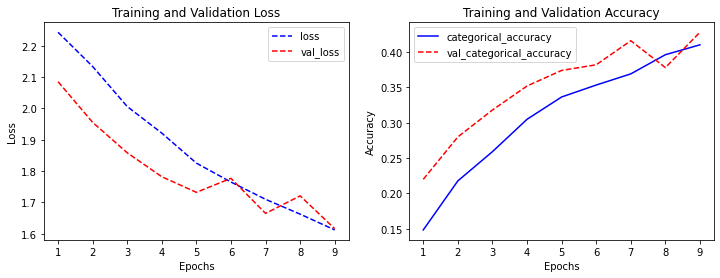

['loss', 'my_categorical_accuracy', 'val_loss', 'val_my_categorical_accuracy']


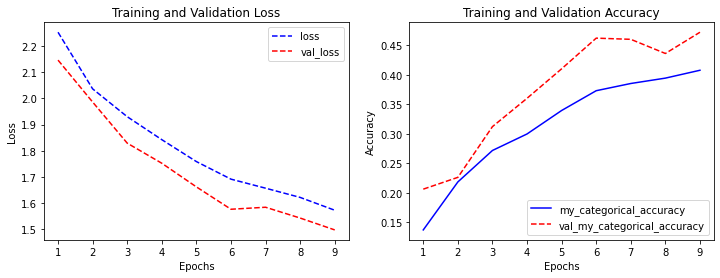

In [22]:
def visual_train_status(history):
    keys = [key for key in history.history.keys()]
    print(keys)
    plt.figure(figsize=(12,4))
    loss = history.history[keys[0]]
    val_loss = history.history[keys[2]]
    epochs = range(1, len(loss)+1)  
    plt.subplot(1,2,1)
    plt.plot(epochs, loss, "b--", label=keys[0])
    plt.plot(epochs, val_loss, "r--", label=keys[2])
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # 顯示訓練和驗證準確度
    acc = history.history[keys[1]]
    val_acc = history.history[keys[3]]
    epochs = range(1, len(acc)+1)
    plt.subplot(1,2,2)
    plt.plot(epochs, acc, "b-", label=keys[1])
    plt.plot(epochs, val_acc, "r--", label=keys[3])
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
    

visual_train_status(history_1)
visual_train_status(history_2)

### 比較兩種方法的訓練結果

In [25]:
model_1.load_weights(model_dir+'/save.h5')
model_2.load_weights(model_dir+'/my_save.h5')
loss_1, acc_1 = model_1.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
loss_2, acc_2 = model_2.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
loss = [loss_1, loss_2]  
acc = [acc_1, acc_2]
dict = {"Loss": loss, "Accuracy": acc}
df = pd.DataFrame(dict)
print(df)

       Loss  Accuracy
0  1.554631     0.429
1  1.505807     0.457
